Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using DynamicHMCModels, ForwardDiff, Flux, ReverseDiff
gr(size=(400,400))

Plots.GRBackend()

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path_d("..", "scripts", "10")
cd(ProjDir)

### snippet 10.4

In [3]:
d = CSV.read(rel_path("..", "data", "chimpanzees.csv"), delim=';');
df = convert(DataFrame, d);
df[!, :pulled_left] = convert(Array{Int64}, df[!, :pulled_left])
df[!, :prosoc_left] = convert(Array{Int64}, df[!, :prosoc_left])
df[!, :condition] = convert(Array{Int64}, df[!, :condition])
df[!, :actor] = convert(Array{Int64}, df[!, :actor])
first(df[!, [:actor, :pulled_left, :prosoc_left, :condition]], 5)

struct m_10_04d_model{TY <: AbstractVector, TX <: AbstractMatrix,
  TA <: AbstractVector}
    "Observations."
    y::TY
    "Covariates"
    X::TX
    "Actors"
    A::TA
    "Number of observations"
    N::Int
    "Number of unique actors"
    N_actors::Int
end

Make the type callable with the parameters *as a single argument*.

In [4]:
function (problem::m_10_04d_model)(θ)
    @unpack y, X, A, N, N_actors = problem   # extract the data
    @unpack β, α = θ  # works on the named tuple too
    ll = 0.0
    ll += sum(logpdf.(Normal(0, 10), β)) # bp & bpC
    ll += sum(logpdf.(Normal(0, 10), α)) # alpha[1:7]
    ll += sum(
      [loglikelihood(Binomial(1, logistic(α[A[i]] + dot(X[i, :], β))), [y[i]]) for i in 1:N]
    )
    ll
end

Instantiate the model with data and inits.

In [5]:
N = size(df, 1)
N_actors = length(unique(df[!, :actor]))
X = hcat(ones(Int64, N), df[!, :prosoc_left] .* df[!, :condition]);
A = df[!, :actor]
y = df[!, :pulled_left]
p = m_10_04d_model(y, X, A, N, N_actors);
θ = (β = [1.0, 0.0], α = [-1.0, 10.0, -1.0, -1.0, -1.0, 0.0, 2.0])
p(θ)

-305.21943396408915

Write a function to return properly dimensioned transformation.

In [6]:
problem_transformation(p::m_10_04d_model) =
    as( (β = as(Array, size(p.X, 2)), α = as(Array, p.N_actors), ) )

problem_transformation (generic function with 1 method)

Wrap the problem with a transformation, then use Flux for the gradient.

In [7]:
P = TransformedLogDensity(problem_transformation(p), p)

TransformedLogDensity of dimension 9

For stress testing

In [8]:
stresstest = false

#ad = :Flux
ad = :ForwardDiff
#ad = :ReverseDiff

if stresstest
  ∇P = ADgradient(ad, P);
  #LogDensityProblems.stresstest(P, N=1000, scale=1.0)
else
  ∇P = LogDensityRejectErrors(ADgradient(ad, P));
end

LogDensityRejectErrors{InvalidLogDensityException,LogDensityProblems.ForwardDiffLogDensity{TransformedLogDensity{TransformVariables.TransformTuple{NamedTuple{(:β, :α),Tuple{TransformVariables.ArrayTransform{TransformVariables.Identity,1},TransformVariables.ArrayTransform{TransformVariables.Identity,1}}}},Main.##477.m_10_04d_model{Array{Int64,1},Array{Int64,2},Array{Int64,1}}},ForwardDiff.GradientConfig{ForwardDiff.Tag{getfield(LogDensityProblems, Symbol("##1#2")){TransformedLogDensity{TransformVariables.TransformTuple{NamedTuple{(:β, :α),Tuple{TransformVariables.ArrayTransform{TransformVariables.Identity,1},TransformVariables.ArrayTransform{TransformVariables.Identity,1}}}},Main.##477.m_10_04d_model{Array{Int64,1},Array{Int64,2},Array{Int64,1}}}},Float64},Float64,9,Array{ForwardDiff.Dual{ForwardDiff.Tag{getfield(LogDensityProblems, Symbol("##1#2")){TransformedLogDensity{TransformVariables.TransformTuple{NamedTuple{(:β, :α),Tuple{TransformVariables.ArrayTransform{TransformVariables.Iden

Run N chains

In [9]:
posterior = Vector{Array{NamedTuple{(:β, :α),Tuple{Array{Float64,1},
  Array{Float64,1}}},1}}(undef, 4)

for i in 1:4
  chain, NUTS_tuned = NUTS_init_tune_mcmc(∇P, 1000);
  posterior[i] = TransformVariables.transform.(Ref(problem_transformation(p)),
    get_position.(chain));
end

MCMC, adapting ϵ (75 steps)
0.014 s/step ...done
MCMC, adapting ϵ (25 steps)
0.015 s/step ...done
MCMC, adapting ϵ (50 steps)
0.0065 s/step ...done
MCMC, adapting ϵ (100 steps)
0.0056 s/step ...done
MCMC, adapting ϵ (200 steps)
0.0033 s/step ...done
MCMC, adapting ϵ (400 steps)
step 397 (of 400), 0.0025 s/step
0.0025 s/step ...done
MCMC, adapting ϵ (50 steps)
0.0031 s/step ...done
MCMC (1000 steps)
step 324 (of 1000), 0.0031 s/step
step 669 (of 1000), 0.003 s/step
0.0029 s/step ...done
MCMC, adapting ϵ (75 steps)
0.014 s/step ...done
MCMC, adapting ϵ (25 steps)
0.019 s/step ...done
MCMC, adapting ϵ (50 steps)
0.0072 s/step ...done
MCMC, adapting ϵ (100 steps)
0.0059 s/step ...done
MCMC, adapting ϵ (200 steps)
0.0036 s/step ...done
MCMC, adapting ϵ (400 steps)
step 360 (of 400), 0.0028 s/step
0.0028 s/step ...done
MCMC, adapting ϵ (50 steps)
0.0027 s/step ...done
MCMC (1000 steps)
step 344 (of 1000), 0.0029 s/step
step 707 (of 1000), 0.0028 s/step
0.0028 s/step ...done
MCMC, adapting ϵ 

Result rethinking

In [10]:
rethinking = "
      mean   sd  5.5% 94.5% n_eff Rhat
a[1] -0.74 0.27 -1.19 -0.31  2899    1
a[2] 10.77 5.20  4.60 20.45  1916    1
a[3] -1.05 0.28 -1.50 -0.62  3146    1
a[4] -1.05 0.28 -1.50 -0.61  3525    1
a[5] -0.73 0.28 -1.17 -0.28  3637    1
a[6]  0.22 0.27 -0.21  0.67  3496    1
a[7]  1.82 0.41  1.21  2.50  3202    1
bp    0.83 0.27  0.42  1.27  2070    1
bpC  -0.13 0.31 -0.62  0.34  3430    1
";

Set varable names

In [11]:
parameter_names = ["bp", "bpC"]
pooled_parameter_names = ["a[$i]" for i in 1:7]

7-element Array{String,1}:
 "a[1]"
 "a[2]"
 "a[3]"
 "a[4]"
 "a[5]"
 "a[6]"
 "a[7]"

Create a3d

In [12]:
a3d = Array{Float64, 3}(undef, 1000, 9, 4);
for j in 1:4
  for i in 1:1000
    a3d[i, 1:2, j] = values(posterior[j][i][1])
    a3d[i, 3:9, j] = values(posterior[j][i][2])
  end
end

chns = MCMCChains.Chains(a3d,
  vcat(parameter_names, pooled_parameter_names),
  Dict(
    :parameters => parameter_names,
    :pooled => pooled_parameter_names
  )
);

Describe the chain

In [13]:
describe(chns)

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean     │ std      │ naive_se  │ mcse       │ ess     │
│     │ Symbol     │ Float64  │ Float64  │ Float64   │ Float64    │ Any     │
├─────┼────────────┼──────────┼──────────┼───────────┼────────────┼─────────┤
│ 1   │ bp         │ 1.42472  │ 3.61649  │ 0.0571818 │ 0.0791148  │ 1993.17 │
│ 2   │ bpC        │ 0.417779 │ 0.253482 │ 0.0040079 │ 0.00394853 │ 4000.0  │

Quantiles

│ Row │ parameters │ 2.5%       │ 25.0%     │ 50.0%    │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64    │ Float64   │ Float64  │ Float64  │ Float64  │
├─────┼────────────┼────────────┼───────────┼──────────┼──────────┼──────────┤
│ 1   │ bp         │ -5.87962   │ -0.998879 │ 1.42059  │ 3.86137  │ 8.43042  │
│ 2   │ bpC        │ -0.0610717 │ 0.24481   │ 0.420515 │ 0.584277 │ 0.916896 │


Describe the chain

In [14]:
describe(chns, sections=[:pooled])

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean      │ std     │ naive_se  │ mcse      │ ess     │
│     │ Symbol     │ Float64   │ Float64 │ Float64   │ Float64   │ Any     │
├─────┼────────────┼───────────┼─────────┼───────────┼───────────┼─────────┤
│ 1   │ a[1]       │ -1.8719   │ 3.62046 │ 0.0572445 │ 0.0797055 │ 1961.2  │
│ 2   │ a[2]       │ 10.0748   │ 5.93104 │ 0.093778  │ 0.137558  │ 1398.43 │
│ 3   │ a[3]       │ -2.17675  │ 3.62108 │ 0.0572543 │ 0.0797274 │ 1987.61 │
│ 4   │ a[4]       │ -2.17638  │ 3.62773 │ 0.0573595 │ 0.0792565 │ 2011.26 │
│ 5   │ a[5]       │ -1.86935  │ 3.6255  │ 0.0573243 │ 0.0791255 │ 2003.11 │
│ 6   │ a[6]       │ -0.940373 │ 3.62568 │ 0.057327  │ 0.0792591 │ 2000.54 │
│ 7   │ a[7]       │ 0.623599  │ 3.63682 │ 0.0575031 │ 0.0799794 │ 1980.1  │

Quantiles

│ Row │ parameters │ 2.5%      │ 25.0%    │ 50.0%     │ 75.0%    │ 97.5%   │
│     │ Symbol     │ Float64   │ Float64  │ Float64   │

Plot the chain parameters

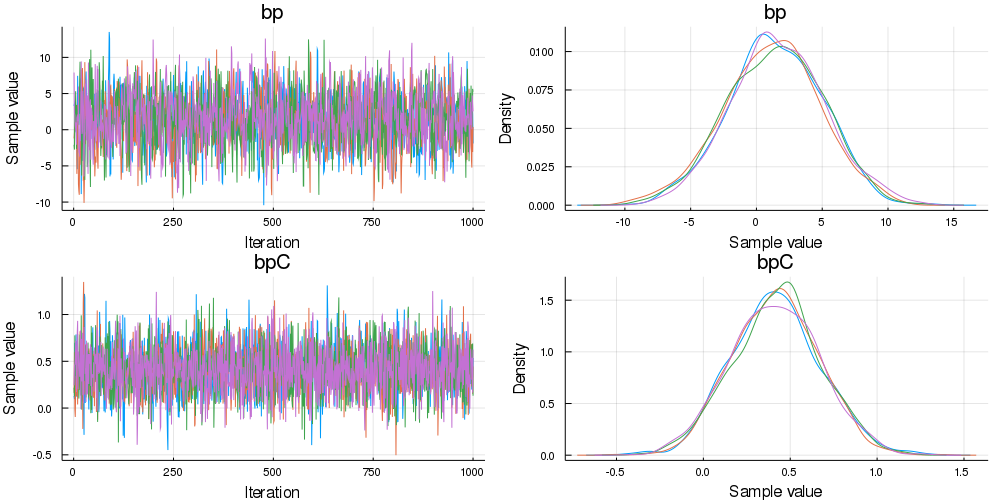

In [15]:
plot(chns)

End of `m10.04d1.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*